# iminuit and automatic differentiation with JAX

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first. 

iminuit's minimization algorithm MIGRAD uses a mix of gradient descent and Newton's method to find the minimum. Both require a first derivative, which MIGRAD usually computes numerically from finite differences. This requires many function evaluations and the gradient may not be accurate. As an alternative, iminuit also allows the user to compute the gradient and pass it to MIGRAD.

Although computing derivatives is often straight-forward, it is usually too much hassle to do manually. Automatic differentiation (AD) is an interesting alternative, it allows one to compute exact derivatives efficiently for pure Python/numpy functions. We demonstrate automatic differentiation with the JAX module, which can not only compute derivatives, but also accelerates the computation of Python code (including the gradient code) with a just-in-time compiler.

[Recommended read: Gentle introduction to AD](https://www.kaggle.com/borisettinger/gentle-introduction-to-automatic-differentiation)

## Example A: Fit of a gaussian model to a histogram

We fit a gaussian to a histogram using a maximum-likelihood approach based on Poisson statistics. This example is used to investigate how automatic differentiation can accelerate a typical fit in a counting experiment.

To compare fits with and without passing an analytic gradient fairly, we use `Minuit.strategy = 0`, which prevents Minuit from automatically computing the Hesse matrix after the fit.

In [1]:
# !pip install jax jaxlib matplotlib

from jax.config import config

config.update("jax_enable_x64", True)  # enable float64 precision
from jax import numpy as np  # replacement for normal numpy
from jax.scipy.special import erf  # replacement for scipy.special.erf
from jax import jit, grad, jacfwd, jacrev
from iminuit import Minuit

import numpy as onp  # original numpy still needed, since jax does not cover full API
from numpy.random import default_rng

We generate some toy data and write the negative log-likelihood (nll) for a fit to binned data, assuming Poisson-distributed counts.

**Note:** We write all statistical functions in pure Python code, to demonstrate Jax's ability to automatically differentiate and JIT compile this code. In practice, one should import JIT-able statistical distributions from jax.scipy.stats. The library versions can be expected to have fewer bugs and to be faster and more accurate than hand-written code.

In [2]:
# generate some toy data
rng = default_rng(seed=1)
w, xe = onp.histogram(rng.normal(0, 1, 10000), bins=1000)

# cdf of a normal distribution, needed to compute the expected counts per bin
def cdf(x, mu, sigma):
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / np.sqrt(2)))


## better alternative for real code:
# from jax.scipy.stats.norm import cdf


def nll(par):  # negative log-likelihood with constants stripped
    amp = par[0]
    rest = par[1:]
    mu = amp * (cdf(xe[1:], *rest) - cdf(xe[:-1], *rest))
    result = np.sum(mu - w * np.log(mu + 1e-100))
    return result

Let's check results from all combinations of using JIT and gradient and then compare the execution times.

|      |     |     |
|:----:|:---:|:---:|
|      |~JIT~| JIT |
|~grad~| m1  | m3  |
| grad | m2  | m4  |

In [3]:
start_values = (1.5 * onp.sum(w), 1.0, 2.0)
limits = ((0, None), (None, None), (0, None))


def make_and_run_minuit(fcn, grad=None):
    m = Minuit(fcn, start_values, grad=grad, name=("amp", "mu", "sigma"))
    m.errordef = Minuit.LIKELIHOOD
    m.limits = limits
    m.strategy = 0
    m.migrad()
    return m

In [4]:
m1 = make_and_run_minuit(nll)
m1.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.936e+04                 │              Nfcn = 66               │
│ EDM = 1.76e-08 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [5]:
m2 = make_and_run_minuit(nll, grad=grad(nll))
m2.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.936e+04                 │              Nfcn = 25               │
│ EDM = 4.95e-05 (Goal: 0.0001)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [6]:
m3 = make_and_run_minuit(jit(nll), grad=grad(nll))
m3.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.936e+04                 │              Nfcn = 25               │
│ EDM = 4.96e-05 (Goal: 0.0001)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [7]:
m4 = make_and_run_minuit(jit(nll), grad=jit(grad(nll)))
m4.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.936e+04                 │              Nfcn = 25               │
│ EDM = 4.96e-05 (Goal: 0.0001)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [8]:
from timeit import timeit

times = {
    "no JIT, no grad": "m1",
    "no JIT, grad": "m2",
    "JIT, no grad": "m3",
    "JIT, grad": "m4",
}
for k, v in times.items():
    t = timeit(
        f"{v}.values = start_values; {v}.migrad()",
        f"from __main__ import {v}, start_values",
        number=1,
    )
    times[k] = t

Just using the JIT compiler is a 1.0-fold increase.
Using JIT and gradient is a 6-fold increase.


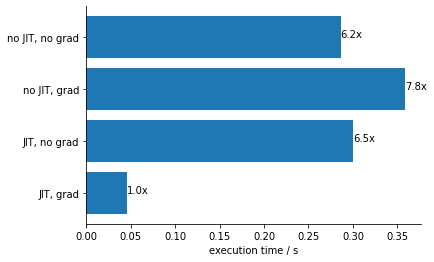

In [9]:
from matplotlib import pyplot as plt

x = onp.fromiter(times.values(), dtype=float)
xmin = np.min(x)

y = -np.arange(4)
plt.barh(y, x)
for yi, k, v in zip(y, times, x):
    plt.text(v, yi, f"{v/xmin:.1f}x")
plt.yticks(y, times.keys())
for loc in ("top", "right"):
    plt.gca().spines[loc].set_visible(False)
plt.xlabel("execution time / s")
print(
    f"""Just using the JIT compiler is a {x[0]/x[2]:.1f}-fold increase.
Using JIT and gradient is a {x[0]/x[3]:.0f}-fold increase."""
)

Conclusions:

1. As expected, the best results are obtained by JIT compiling the function and the gradient.

2. JIT compiling the cost function with Jax is only a minor performance improvement (numba is able to do much better). 

3. JIT compiling the gradient is important. Using a pure-Python gradient decreases performance in this example.


The gain from using a gradient is larger for functions with hundreds of parameters, as is common in machine learning. Human-made models often have less than 10 parameters, and then the gain is not so dramatic. 

### Computing covariance matrices with JAX

Automatic differentiation gives us another way to compute uncertainties of fitted parameters. MINUIT compute the uncertainties with the HESSE algorithm by default, which computes the matrix of second derivates approximately using finite differences and inverts this.

Let's compare the output of HESSE with the exact (within floating point precision) computation using automatic differentiation.

In [10]:
m4.hesse()
cov_hesse = m4.covariance


def jax_covariance(par):
    hessian = jacfwd(jacrev(nll))
    return np.linalg.inv(hessian(par))


par = np.array(m4.values)
cov_jax = jax_covariance(par)

print(
    f"sigma[amp]  : HESSE = {cov_hesse[0, 0] ** 0.5:6.1f}, JAX = {cov_jax[0, 0] ** 0.5:6.1f}"
)
print(
    f"sigma[mu]   : HESSE = {cov_hesse[1, 1] ** 0.5:6.4f}, JAX = {cov_jax[1, 1] ** 0.5:6.4f}"
)
print(
    f"sigma[sigma]: HESSE = {cov_hesse[2, 2] ** 0.5:6.4f}, JAX = {cov_jax[2, 2] ** 0.5:6.4f}"
)

sigma[amp]  : HESSE =  100.0, JAX =  100.0
sigma[mu]   : HESSE = 0.0100, JAX = 0.0100
sigma[sigma]: HESSE = 0.0071, JAX = 0.0071


Success, HESSE and JAX give the same answer within the  relevant precision.

**Note:** If you compute the covariance matrix in this way from a least-squares cost function, you must multiply it by 2.

Let us compare the performance of HESSE with Jax.

In [11]:
%%timeit -n 1 -r 3
m = Minuit(nll, par)
m.errordef = Minuit.LIKELIHOOD
m.hesse()

92.5 ms ± 8.64 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
%%timeit -n 1 -r 3
jax_covariance(par)

97.4 ms ± 7.31 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The computation with Jax is faster, but not by much. It is also more accurate (although the added precision is not relevant).

Altogether, Minuit's HESSE algorithm still makes sense today. It has the advantage that it can process any function, while Jax cannot. Jax cannot differentiate a function that calls into C/C++ code or Cython code, for example.

Final note: If we JIT compile `jax_covariance`, it greatly outperforms Minuit's HESSE algorithm.

In [13]:
%%timeit -n 1 -r 3 jit_jax_covariance = jit(jax_covariance); jit_jax_covariance(par)
jit_jax_covariance(par)

216 µs ± 29.6 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


It is much faster... but only because the compilation cost is excluded here.

In [14]:
%%timeit -n 1 -r 1
# if we include the JIT compilation cost, the performance drops dramatically
@jit
def jax_covariance(par):
    hessian = jacfwd(jacrev(nll))
    return np.linalg.inv(hessian(par))


jax_covariance(par)

938 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


With compilation cost included, it is much slower.

Conclusion: Using the JIT compiler makes a lot of sense if the covariance matrix has to be computed repeatedly for the same cost function but different parameters, but this is not the common case in practice.

## Example B: Fit data points with uncertainties in x and y

Let's say we have some data points $(x_i \pm \sigma_{x,i}, y_i \pm \sigma_{y,i})$ and we have a model $y=f(x)$ that we want to adapt to this data. If $\sigma_{x,i}$ was zero, we could use the usual least-squares method, minimizing the sum of squared residuals $r^2_i = (y_i - f(x_i))^2 / \sigma^2_{y,i}$. Here, we don't know where to evaluate $f(x)$, since the exact $x$-location is only known up to $\sigma_{x,i}$.

We can approximately extend the standard least-squares method to handle this case. We use that the uncertainty along the $x$-axis can be converted into an additional uncertainty along the $y$-axis with error propagation,
$$
f(x_i \pm \sigma_{x,i}) \simeq f(x_i) \pm f'(x_i)\,\sigma_{x,i}.
$$
Using this, we obtain modified squared residuals
$$
r^2_i = \frac{(y_i - f(x_i))^2}{\sigma^2_{y,i} + (f'(x_i) \,\sigma_{x,i})^2}.
$$

We demonstrate this with a fit of a polynomial.

In [15]:
# polynomial model
def f(x, par):
    return np.polyval(par, x)


# true polynomial f(x) = x^2 + 2 x + 3
par_true = (1, 2, 3)


# grad computes derivative with respect to the first argument
f_prime = jit(grad(f))


# checking first derivative f'(x) = 2 x + 2
assert f_prime(0.0, par_true) == 2
assert f_prime(1.0, par_true) == 4
# ok!

# generate toy data
n = 30
data_x = np.linspace(-4, 7, n)
data_y = f(data_x, par_true)

rng = default_rng(seed=1)
sigma_x = 0.5
sigma_y = 5
data_x += rng.normal(0, sigma_x, n)
data_y += rng.normal(0, sigma_y, n)

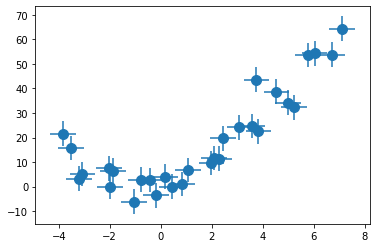

In [16]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o");

In [17]:
# define the cost function
@jit
def cost(par):
    result = 0.0
    for xi, yi in zip(data_x, data_y):
        y_var = sigma_y ** 2 + (f_prime(xi, par) * sigma_x) ** 2
        result += (yi - f(xi, par)) ** 2 / y_var
    return result


# test the jit-ed function
cost(np.zeros(3))

DeviceArray(876.49545695, dtype=float64)

In [18]:
m = Minuit(cost, np.zeros(3))
m.errordef = Minuit.LEAST_SQUARES
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.14                      │              Nfcn = 91               │
│ EDM = 3.12e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.25    │   0.15    │            │            │         │         │       │
│ 1 │ x1   │    1.5    │    0.5    │            │            │         │         │       │
│ 2 │ x2   │    1.6    │    1.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │     x0     x1     x2 │
├────┼──────────────────────┤
│ x0 │  0.022 -0.039 -0.150 │
│ x1 │ -0.039  0.240  0.172 │
│ x2 │ -0.150  0.172  2.322 │
└────┴──────────────────────┘

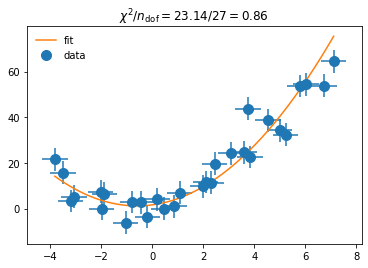

In [19]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o", label="data")
x = np.linspace(data_x[0], data_x[-1], 200)
plt.plot(x, f(x, m.values), label="fit")
plt.legend()

# check fit quality
chi2 = m.fval
ndof = len(data_y) - 3
plt.title(f"$\\chi^2 / n_\\mathrm{{dof}} = {chi2:.2f} / {ndof} = {chi2/ndof:.2f}$");

We obtained a good fit.